# **CUSTOMER CHURN PREDICTION USING XGBOOST ON MARKETING DATA**

Churn prediction using XGBoost on marketing data can be a powerful technique to identify customers who are likely to leave a service or product. XGBoost (Extreme Gradient Boosting) is a popular machine learning algorithm known for its performance and efficiency in handling large datasets.

# **Importing necessary packages for the analysis.**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
sns.set_style("darkgrid")

import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
CampaignDesc = pd.read_csv('/content/campaign_desc.csv')
CampaignTable = pd.read_csv('/content/campaign_table.csv')
CausalData = pd.read_csv('/content/causal_data.csv')
Coupon = pd.read_csv('/content/coupon.csv')
CouponRedempt = pd.read_csv('/content/coupon_redempt.csv')
Demographic = pd.read_csv('/content/hh_demographic.csv')
Product = pd.read_csv('/content/product.csv')
Transaction = pd.read_csv('/content/transaction_data.csv')


In [ ]:
CampaignDesc.head()

,DESCRIPTION,CAMPAIGN,START_DAY,END_DAY
0,TypeB,24,659,719
1,TypeC,15,547,708
2,TypeB,25,659,691
3,TypeC,20,615,685
4,TypeB,23,646,684


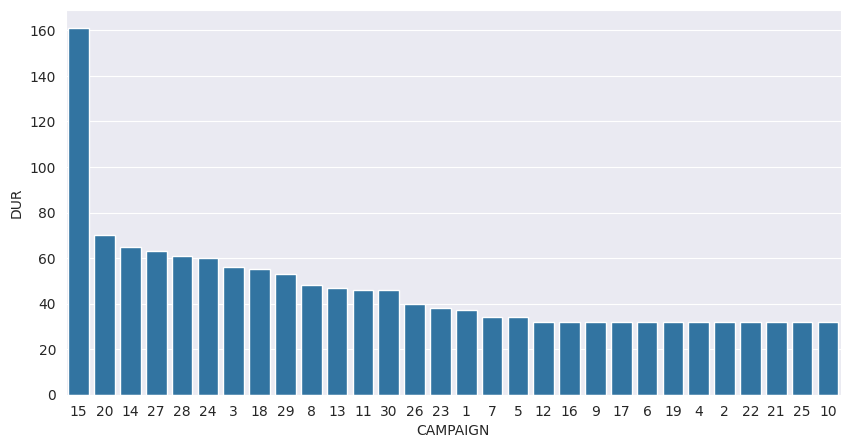

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming "CampaignDesc" is your DataFrame
CampaignDesc["DUR"] = CampaignDesc["END_DAY"] - CampaignDesc["START_DAY"]

# Plotting
fig = plt.figure(figsize=(10, 5))
sns.barplot(x="CAMPAIGN", y="DUR", data=CampaignDesc, order=CampaignDesc.sort_values(by="DUR", ascending=False)["CAMPAIGN"])
plt.show()

# **Campaign¶**
Campaign dataset contains identifying information for the marketing campaigns each household participated in.

In [ ]:
CampaignTable.head()

,DESCRIPTION,household_key,CAMPAIGN
0,TypeA,17,26
1,TypeA,27,26
2,TypeA,212,26
3,TypeA,208,26
4,TypeA,192,26


In [ ]:
total_households = 2500
unique_households = len(CampaignTable["household_key"].unique())
unique_households

1584

Out of 2500 households, 1584 of them received a campaign once, the rest never received a campaign.

On the other side, a very small portion of the households received double-digit number of campaigns. We will investigate how this will effect churn rates in the following sections. The barchart below groups the households and shows counts of the group populations.


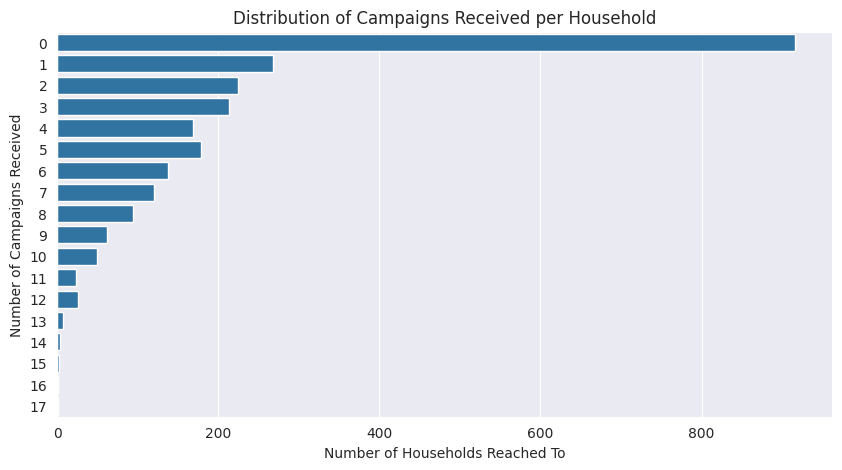

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the number of received campaigns per household
no_of_received_campaigns_per_house = CampaignTable["household_key"].value_counts()

# Calculate the number of households that received a specific number of campaigns
no_of_received_campaigns = no_of_received_campaigns_per_house.value_counts()

# Calculate the number of households that did not receive any campaign
no_of_received_campaigns[0] = total_households - len(no_of_received_campaigns_per_house)

# Create a DataFrame from the calculated values
no_of_received_campaigns_df = pd.DataFrame({
    "Number of Campaigns Received": no_of_received_campaigns.index,
    "Number of Households Reached To": no_of_received_campaigns.values
}).sort_values(by="Number of Campaigns Received", ascending=True)

# Plotting
plt.figure(figsize=(10, 5))
sns.barplot(y="Number of Campaigns Received", x="Number of Households Reached To", data=no_of_received_campaigns_df, orient="h", order=no_of_received_campaigns_df["Number of Campaigns Received"])
plt.xlabel("Number of Households Reached To")
plt.ylabel("Number of Campaigns Received")
plt.title("Distribution of Campaigns Received per Household")
plt.show()



"The graph below illustrates the most frequent campaigns. Notably, Campaigns 18, 13, and 8 emerge as the most prevalent ones, each reaching over 1000 households. It's worth mentioning that no campaign was applied to the same customer more than once; hence, the frequency axis represents the unique number of households reached."

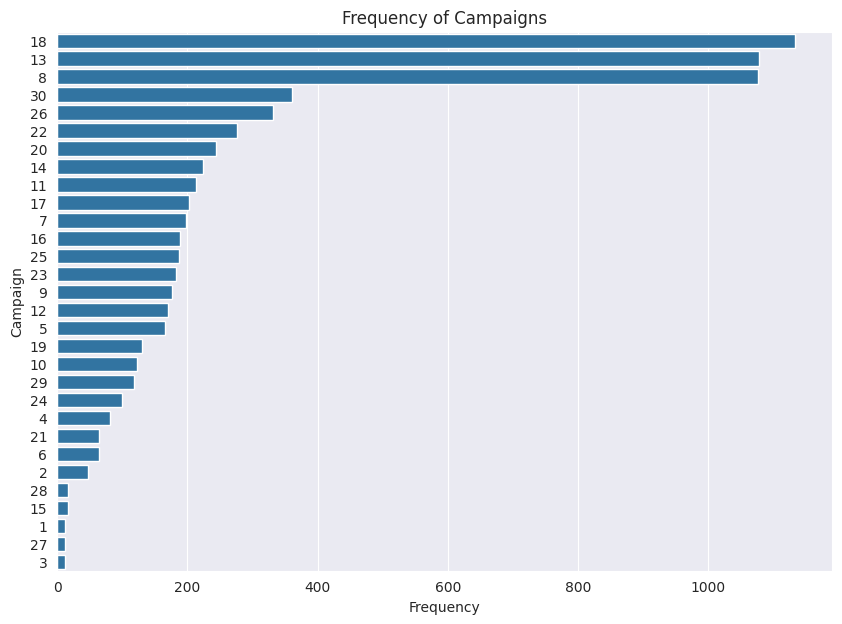

In [ ]:
# Assuming "campaignTable" is your DataFrame
freq_campaigns = pd.DataFrame(list(zip(CampaignTable["CAMPAIGN"].value_counts().index, CampaignTable["CAMPAIGN"].value_counts())), columns=["Campaign", "Frequency"])

# Plotting
fig = plt.figure(figsize=(10, 7))
sns.barplot(y="Campaign", x="Frequency", data=freq_campaigns, orient="h", order=freq_campaigns["Campaign"])
plt.xlabel("Frequency")
plt.ylabel("Campaign")
plt.title("Frequency of Campaigns")
plt.show()

# **Coupons¶**
Is a lookup table which lists all the coupons sent to customers as part of a campaign, as well as the products for which each coupon is redeemable

In [ ]:
Coupon.head()

,COUPON_UPC,PRODUCT_ID,CAMPAIGN
0,10000089061,27160,4
1,10000089064,27754,9
2,10000089073,28897,12
3,51800009050,28919,28
4,52100000076,28929,25


# **Coupon Redemptions**
Is a data table, ordered by household_key, gives which household redeemed what coupon number. Also the day of the redeem and the campaign number is given for each household.

In [ ]:
CouponRedempt.head()

,household_key,DAY,COUPON_UPC,CAMPAIGN
0,1,421,10000085364,8
1,1,421,51700010076,8
2,1,427,54200000033,8
3,1,597,10000085476,18
4,1,597,54200029176,18


In [ ]:
len(CouponRedempt["household_key"].unique())


434

"Within this period, only 434 out of 2500 households (17%) redeemed coupons."

"As expected, the most frequent campaigns (Campaigns 18, 13, and 8, all belonging to TypeA) attracted the highest number of redemptions. The bar chart below displays the number of redemptions per campaign."

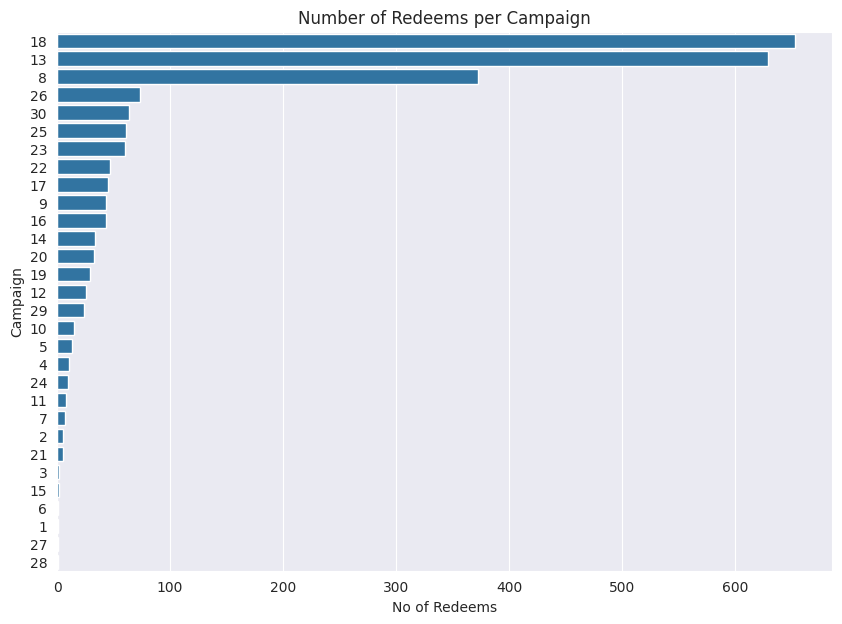

In [ ]:

#  DataFrame
redeem_frequency = pd.DataFrame(list(zip(CouponRedempt["CAMPAIGN"].value_counts().index, CouponRedempt["CAMPAIGN"].value_counts())), columns=["Campaign", "No of Redeems"])

# Plotting
fig = plt.figure(figsize=(10, 7))
sns.barplot(y="Campaign", x="No of Redeems", data=redeem_frequency, orient="h", order=redeem_frequency["Campaign"])
plt.xlabel("No of Redeems")
plt.ylabel("Campaign")
plt.title("Number of Redeems per Campaign")
plt.show()

"The bar chart below displays the redeem rates of each campaign in descending order. Notably, Campaigns 13 and 18 exhibit significantly higher redeem rates, approximately 60%, compared to other campaigns. These results indicate that campaign organizers effectively promoted the most successful campaigns (13 and 18) more frequently."

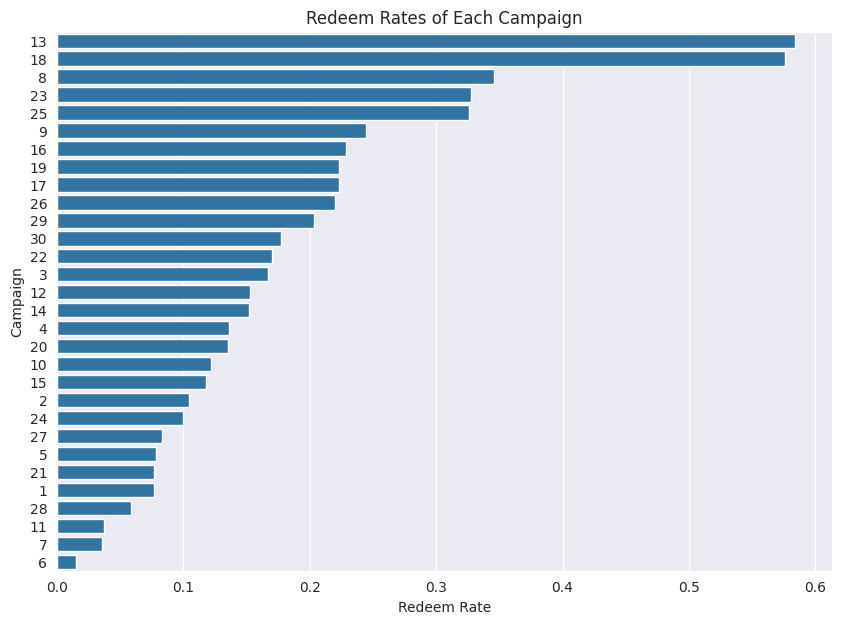

In [ ]:
# Calculate the redemption rates for each campaign
redems_per_camp = CouponRedempt["CAMPAIGN"].value_counts().sort_index() / CampaignTable["CAMPAIGN"].value_counts().sort_index()

# Create a DataFrame with redemption rates
redems_per_camp_df = pd.DataFrame({
    "Campaign": redems_per_camp.index,
    "Redeem_Rate": redems_per_camp.values
}).sort_values(by="Redeem_Rate", ascending=False)

# Plotting
plt.figure(figsize=(10, 7))
sns.barplot(y="Campaign", x="Redeem_Rate", data=redems_per_camp_df, orient="h", order=redems_per_camp_df["Campaign"])
plt.xlabel("Redeem Rate")
plt.ylabel("Campaign")
plt.title("Redeem Rates of Each Campaign")
plt.show()

# **Transactional Data**
Transactional data contains purchase history of each household. It contains the product ID and sales value, store ID and all other transactional features.

In [ ]:
Transaction.head()

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
0,2375,26984851472,1,1004906.0,1.0,1.39,364.0,-0.60,1631.0,1.0,0.0,0.0
1,2375,26984851472,1,1033142.0,1.0,0.82,364.0,0.00,1631.0,1.0,0.0,0.0
2,2375,26984851472,1,1036325.0,1.0,0.99,364.0,-0.30,1631.0,1.0,0.0,0.0
3,2375,26984851472,1,1082185.0,1.0,1.21,364.0,0.00,1631.0,1.0,0.0,0.0
4,2375,26984851472,1,8160430.0,1.0,1.50,364.0,-0.39,1631.0,1.0,0.0,0.0


"Now, let's conduct some descriptive analysis on the transactional data. To start, we'll group the data by household numbers."

In [ ]:
grouped_sum = Transaction.groupby("household_key").sum()

"The average amount of purchases made by a household within these two years is:"

In [ ]:
av_purc = round(Transaction.SALES_VALUE.sum()/len(grouped_sum),1)
av_purc

2206.8

"The average total number of products purchased by a household within two years is:"

In [ ]:
av_tot_prod = round(grouped_sum["QUANTITY"].mean(),1)
av_tot_prod

69990.4

"The average total number of unique products purchased by a household within two years is:"

In [ ]:
av_uniq_prod = round(len(Transaction.groupby(["household_key","PRODUCT_ID"]).sum()["QUANTITY"])/len(grouped_sum),1)
av_uniq_prod

414.7

Average number of store visits per household within two years is:

In [ ]:
av_days_visited = round(len(Transaction.groupby(["household_key","DAY"]).count())/len(grouped_sum),1)
av_days_visited

62.7

"Below, we've calculated and plotted the top 20 stores based on total sales amount (in USD). Stores with IDs 367 and 406 led the pack, each generating over $200,000 in sales, out of a total of 582 stores."

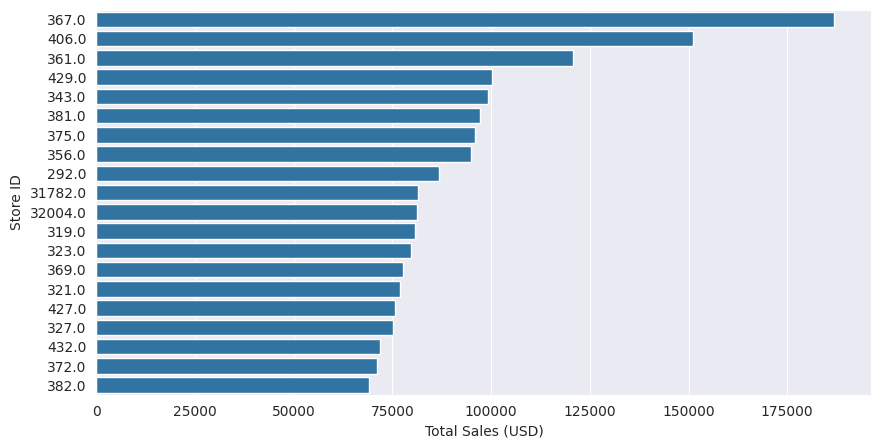

In [ ]:
sales_per_store = Transaction.groupby("STORE_ID").sum()["SALES_VALUE"].sort_values(ascending=False)
sales_per_store = pd.DataFrame(list(zip(sales_per_store.index,sales_per_store)),columns=["Store ID","Total Sales (USD)"])
fig_store = plt.figure(figsize=(10,5))
sns.barplot(y="Store ID",x="Total Sales (USD)",data = sales_per_store[:20],order=sales_per_store[:20]["Store ID"],orient="h")
plt.show()

"Below, we've calculated and displayed the top 20 customers based on total purchase amount (in USD). The top customer, with ID 1023, made the most purchases among the 2500 households, totaling nearly $40,000."

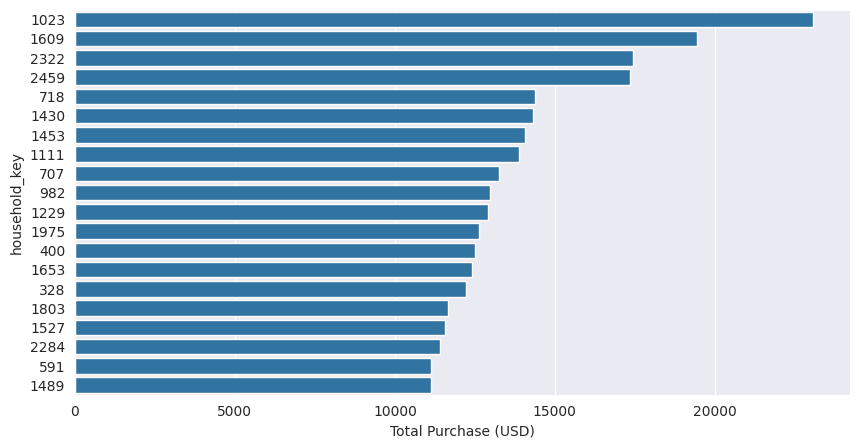

In [ ]:
purc_per_cust = Transaction.groupby("household_key").sum()["SALES_VALUE"].sort_values(ascending=False)
purc_per_cust = pd.DataFrame(list(zip(purc_per_cust.index,purc_per_cust)),columns=["household_key","Total Purchase (USD)"])
fig_store = plt.figure(figsize=(10,5))
sns.barplot(y="household_key",x="Total Purchase (USD)",data = purc_per_cust[:20],order=purc_per_cust[:20]["household_key"],orient="h")
plt.show()

# **Demographic Data**

"Demographics data include household demographic information, such as age group, marital status, and household size. This table serves as the foundation, and we will augment it with additional columns through feature engineering. The target variable for churn prediction will be incorporated into the final dataset before proceeding to predictive modeling.

In [ ]:
Demographic.head()

,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,household_key
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def pie_categorical(data):
    # Calculate dynamic numbers of subplot rows and columns
    num_features = len(data.columns)
    cols = int(np.ceil(np.sqrt(num_features)))
    rows = int(np.ceil(num_features / cols))

    # Create a figure for pie charts
    fig_pie_cat = plt.figure(figsize=(15, 15))
    count = 1

    # Plot pie charts for each categorical variable
    for feature in data.columns:
        ax = fig_pie_cat.add_subplot(rows, cols, count)
        data[feature].value_counts().plot(kind="pie", autopct="%.1f%%", ax=ax)
        ax.set_ylabel("")
        ax.set_title(feature, fontweight="bold", fontsize=8)
        count += 1

    plt.show()


"Since all variables in the demographics dataset are categorical, we utilized our 'pie_categorical' function. The pie charts below illustrate the distribution of each categorical variable in the demographics dataset.

Some notable findings:

The majority of customers fall within the age range
of 35-54 (~60%).
Married couples outnumber singles by almost threefold.
Approximately half of the population earns a yearly salary between $35,000 and $74,000.
A majority of customers own a house (63%).
Nearly 70% of customers do not have children."

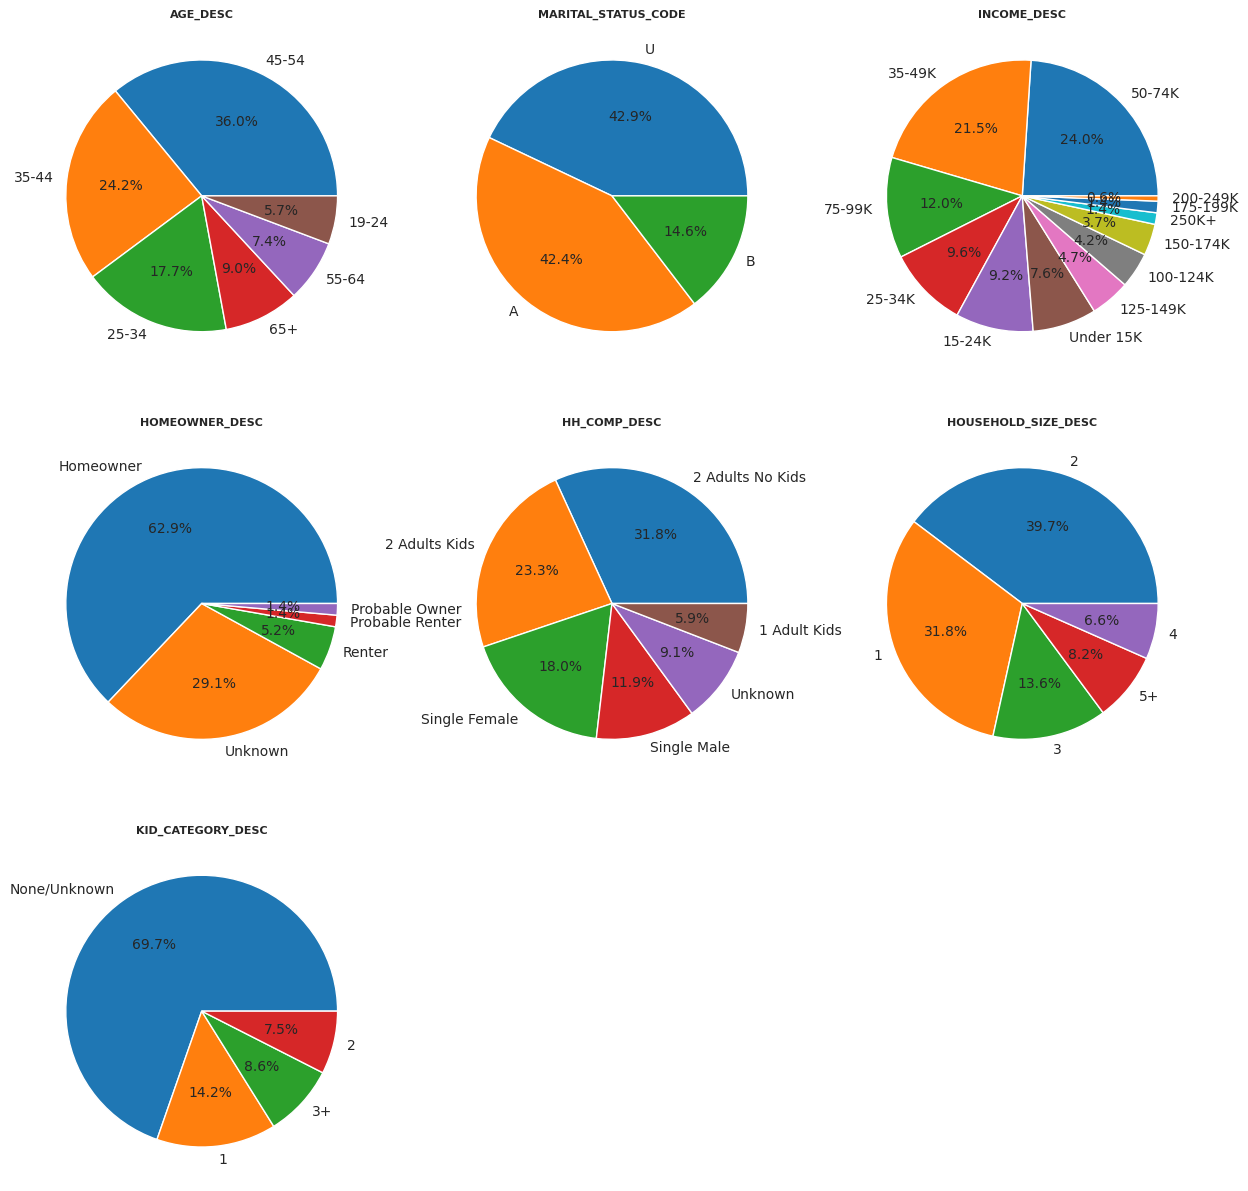

In [ ]:
pie_categorical(Demographic.drop("household_key",axis=1))